# Homework - Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, mean_squared_error

RANDOM_SEED = 42

## Getting the data

In [2]:
data = pd.read_csv("../data/housing.csv.zip")
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


### Data prepration

In [4]:
data.fillna(0)

data["rooms_per_household"] = data["total_rooms"] / data["households"]
data["bedrooms_per_room"] = data["total_bedrooms"] / data["total_rooms"]
data["population_per_household"] = data["population"] / data["households"]

## Question 1
What is the most frequent observation (mode) for the column `ocean_proximity`?

In [5]:
data["ocean_proximity"].mode()

0    <1H OCEAN
Name: ocean_proximity, dtype: object

## Splitting the data

In [6]:
X_full_train, X_test, y_full_train, y_test = train_test_split(data.drop("median_house_value", axis=1),
                                                data["median_house_value"], 
                                                train_size=.8, 
                                                random_state=RANDOM_SEED)

X_train, X_valid, y_train, y_valid = train_test_split(X_full_train, y_full_train, train_size=.75, random_state=RANDOM_SEED)

In [7]:
X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

## Question 2
- Create the correlation matrix for the numerical features of your train dataset.
  - In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.
- What are the two features that have the biggest correlation in this dataset?

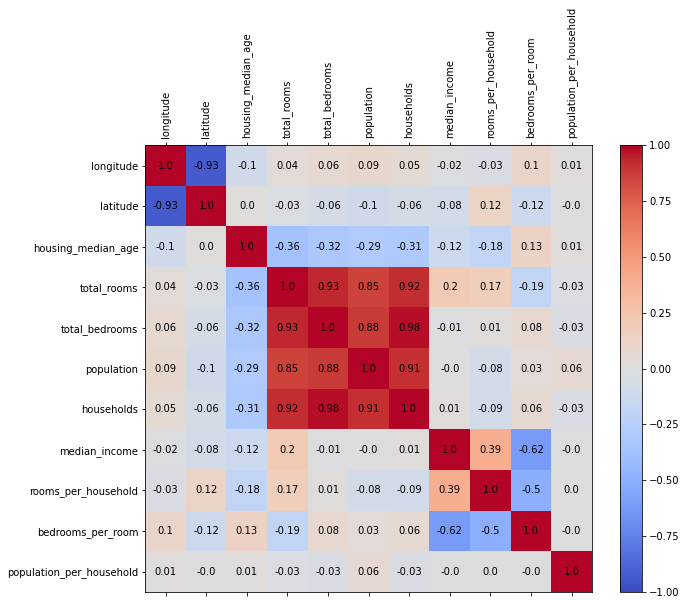

In [8]:
def plot_correlation_matrix(data):
    corr_matrix = data.corr()
    columns = corr_matrix.columns

    plt.figure(figsize=(10, 8))
    plt.matshow(corr_matrix, fignum=1, cmap="coolwarm", vmin=-1, vmax=1)
    plt.xticks(range(len(columns)), columns, rotation=90)
    plt.yticks(range(len(columns)), columns)

    for index, elem in np.ndenumerate(corr_matrix):
        plt.text(index[0], index[1], str(round(elem, 2)), ha="center", va="center")
    
    plt.colorbar()
    plt.show()

plot_correlation_matrix(X_train)

`total_bedrooms` and `households` have the highest correlation in the dataset.

## Make `median_house_value` binary

In [9]:
median_house_value_avg = data["median_house_value"].mean()
y_train_above_averge = [1 if value > median_house_value_avg else 0 for value in y_train]
y_val_above_averge = [1 if value > median_house_value_avg else 0 for value in y_valid]
y_test_above_averge = [1 if value > median_house_value_avg else 0 for value in y_test]

## Question 3
- Calculate the mutual information score with the (binarized) price for the categorical variable that we have. Use the training set only.
- What is the value of mutual information?
- Round it to 2 decimal digits using round(score, 2)

In [10]:
round(mutual_info_score(y_train_above_averge, X_train["ocean_proximity"]), 2)

0.1

## Question 4
- Now let's train a logistic regression
- Remember that we have one categorical variable `ocean_proximity` in the data. Include it using one-hot encoding.
- Fit the model on the training dataset.
- To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
  - `model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)`
- Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

In [11]:
enc = OneHotEncoder(sparse=False)
enc_df = pd.DataFrame(enc.fit_transform(X_train[["ocean_proximity"]]), columns=enc.get_feature_names_out())
X_train = X_train.drop("ocean_proximity", axis=1).join(enc_df)

X_valid = X_valid.join(pd.DataFrame(enc.transform(X_valid[["ocean_proximity"]]), columns=enc.get_feature_names_out()))
X_valid.drop("ocean_proximity", axis=1, inplace=True)

model = LogisticRegression(solver="liblinear", C=1, max_iter=1000, random_state=RANDOM_SEED)
model.fit(X_train, y_train_above_averge)
y_pred = model.predict(X_valid)

In [12]:
accuracy = accuracy_score(y_val_above_averge, y_pred)
print(round(accuracy, 2))

0.84


## Question 5
- Let's find the least useful feature using the *feature elimination* technique.
- Train a model with all these features (using the same parameters as in Q4).
- Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
- For each feature, calculate the difference between the original accuracy and the accuracy without the feature.
- Which of following feature has the smallest difference?
  - `total_rooms`
  - `total_bedrooms`
  - `population`
  - `households`

In [13]:
def get_accuracies_feature_elimination(X_train, y_train, X_valid, y_valid, accuracy):
    accs = {}
    for feature in X_train.columns:
        model.fit(X_train.drop(feature, axis=1), y_train)
        y_pred = model.predict(X_valid.drop(feature, axis=1))

        accs[feature] = [accuracy_score(y_valid, y_pred), abs(accuracy - accuracy_score(y_valid, y_pred))]
    return accs

accs = get_accuracies_feature_elimination(X_train, y_train_above_averge, X_valid, y_val_above_averge, accuracy)

In [14]:
pd.DataFrame.from_dict(accs, orient="index")[1].sort_values()[:1]

total_bedrooms    0.000242
Name: 1, dtype: float64

## Question 6
- For this question, we'll see how to use a linear regression model from Scikit-Learn
- We'll need to use the original column `'median_house_value'`. Apply the logarithmic transformation to this column.
- Fit the Ridge regression model (`model = Ridge(alpha=a, solver="sag", random_state=42)`) on the training data.
- This model has a parameter `alpha`. Let's try the following values: `[0, 0.01, 0.1, 1, 10]`
- Which of these alphas leads to the best RMSE on the validation set? Round your RMSE scores to 3 decimal digits.

In [15]:
y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)

In [17]:
alphas = [0, 0.01, 0.1, 1, 10]
scores = {}

def get_scores_from_ridge(X_train, X_valid, y_train, y_valid):
    for a in alphas:
        model = Ridge(alpha=a, solver="sag", random_state=RANDOM_SEED)
        model.fit(X_train, y_train_log)
        y_pred = model.predict(X_valid)
        scores[a] = round(mean_squared_error(y_valid_log, y_pred, squared=False), 3)
    return scores

get_scores_from_ridge(X_train, X_valid, y_train_above_averge, y_val_above_averge)

{0: 0.524, 0.01: 0.524, 0.1: 0.524, 1: 0.524, 10: 0.524}